Energy Consumption Time Series Forecasting

Models: ARIMA, Prophet, XGBoost
Metrics: MAE, RMSE
Visualization: Actual vs Forecast

In [1]:
import matplotlib.pyplot as plt

In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Machine learning
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Importing plotly failed. Interactive plots will not work.


In [3]:
# Load dataset
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=";",
    low_memory=False,
    na_values="?"
)

In [4]:
# Combine Date and Time into single datetime column
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

# Set datetime as index
df.set_index("datetime", inplace=True)

# Convert target column to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"])


In [5]:
# Forward fill missing values
df = df.fillna(method="ffill")


In [6]:
# Hourly energy consumption
hourly_df = df["Global_active_power"].resample("H").mean()

# Convert to DataFrame
hourly_df = hourly_df.to_frame(name="energy")


In [7]:
# Create time features
hourly_df["hour"] = hourly_df.index.hour
hourly_df["day"] = hourly_df.index.day
hourly_df["month"] = hourly_df.index.month
hourly_df["weekday"] = hourly_df.index.weekday

# Weekend flag
hourly_df["is_weekend"] = hourly_df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

In [8]:
# Split data (last 20% for testing)
train_size = int(len(hourly_df) * 0.8)

train = hourly_df.iloc[:train_size]
test = hourly_df.iloc[train_size:]


MODEL 1: ARIMA

In [9]:
# Fit ARIMA model
arima_model = ARIMA(train["energy"], order=(5,1,2))
arima_fit = arima_model.fit()


In [10]:
# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))


In [11]:
arima_mae = mean_absolute_error(test["energy"], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test["energy"], arima_forecast))


MODEL 2: PROPHET

In [12]:
prophet_train = train.reset_index()[["datetime", "energy"]]
prophet_train.columns = ["ds", "y"]


In [13]:
prophet_model = Prophet()
prophet_model.fit(prophet_train)


16:42:39 - cmdstanpy - INFO - Chain [1] start processing
16:42:48 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = prophet_model.make_future_dataframe(periods=len(test), freq="H")
prophet_forecast = prophet_model.predict(future)

# Extract forecasted values
prophet_pred = prophet_forecast["yhat"].iloc[-len(test):].values


In [15]:
prophet_mae = mean_absolute_error(test["energy"], prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(test["energy"], prophet_pred))


MODEL 3: XGBOOST

In [16]:
features = ["hour", "day", "month", "weekday", "is_weekend"]

X_train = train[features]
y_train = train["energy"]

X_test = test[features]
y_test = test["energy"]


In [17]:
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
xgb_pred = xgb_model.predict(X_test)


In [19]:
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))


In [24]:
results = pd.DataFrame({"Model": ["ARIMA", "Prophet", "XGBoost"],"MAE": [arima_mae, prophet_mae, xgb_mae],"RMSE": [arima_rmse, prophet_rmse, xgb_rmse]})

print(results)


     Model       MAE      RMSE
0    ARIMA  0.768817  0.886303
1  Prophet  0.493905  0.646140
2  XGBoost  0.448605  0.615659


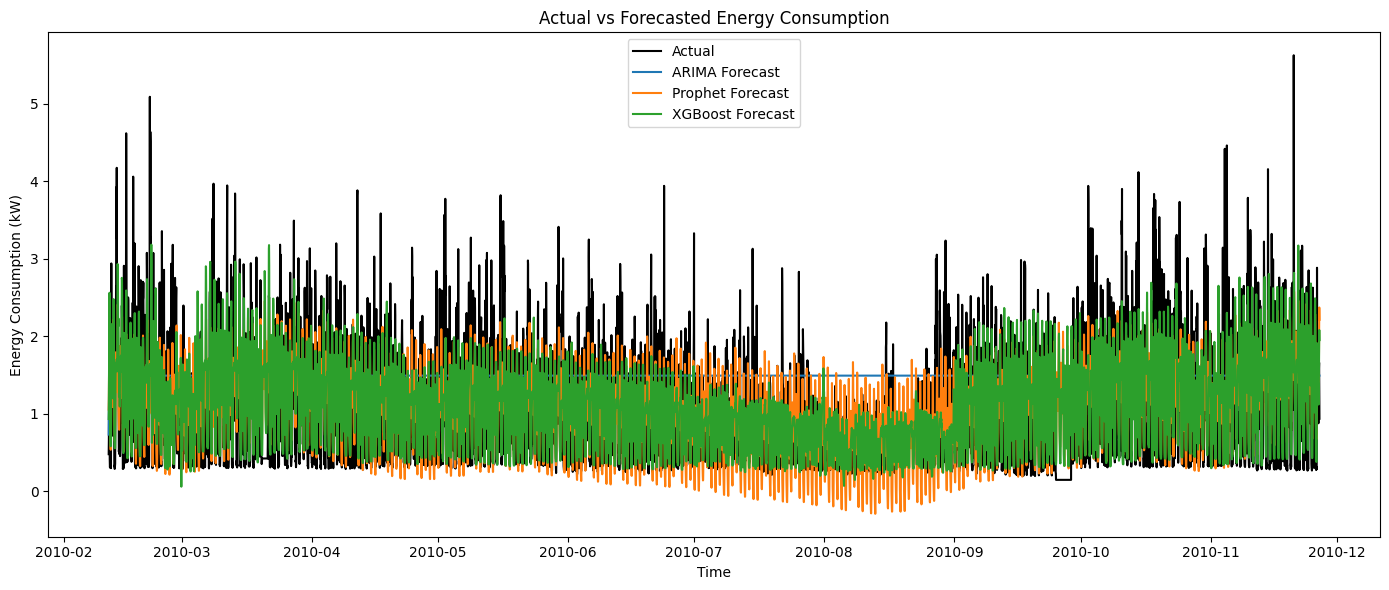

In [25]:
plt.figure(figsize=(14,6))

plt.plot(test.index, test["energy"], label="Actual", color="black")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.plot(test.index, prophet_pred, label="Prophet Forecast")
plt.plot(test.index, xgb_pred, label="XGBoost Forecast")

plt.title("Actual vs Forecasted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kW)")
plt.legend()
plt.tight_layout()
plt.show()


The plot focuses on the most recent 7 days to clearly evaluate short-term forecasting performance. Limiting the time window improves interpretability while preserving temporal patterns.

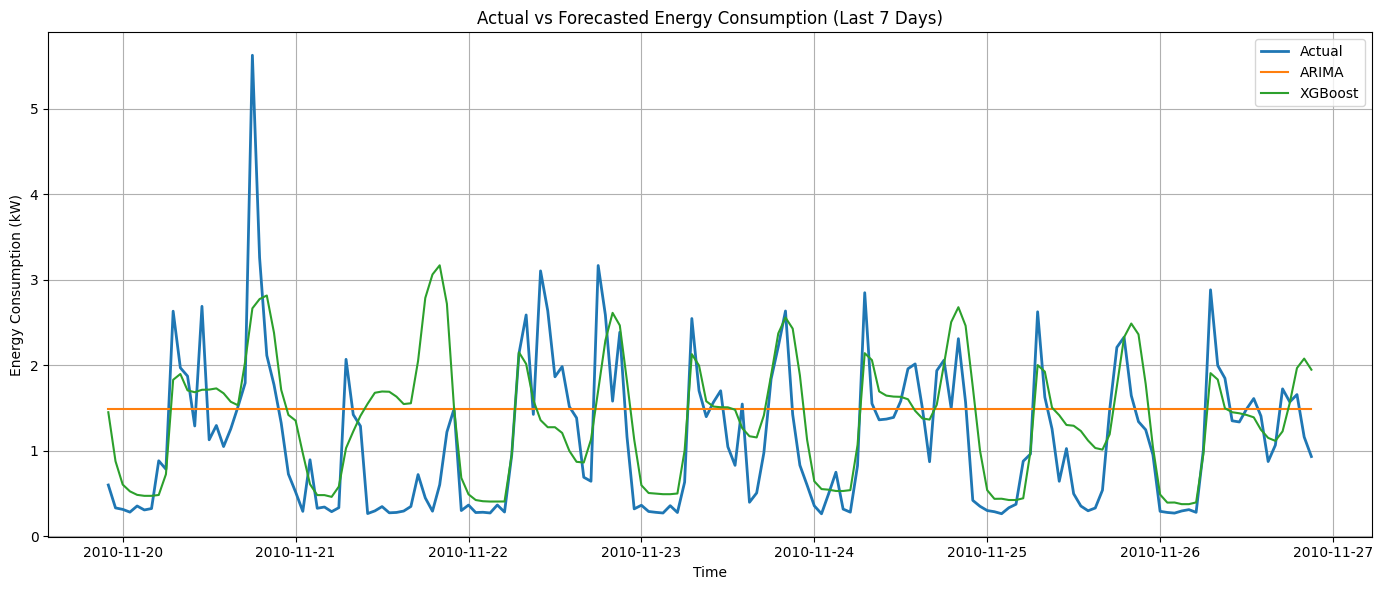

In [26]:
# Plot only last 7 days
plot_range = 24 * 7  

plt.figure(figsize=(14,6))

plt.plot(test.index[-plot_range:], test["energy"][-plot_range:], 
         label="Actual", linewidth=2)

plt.plot(test.index[-plot_range:], arima_forecast[-plot_range:], 
         label="ARIMA")

plt.plot(test.index[-plot_range:], xgb_pred[-plot_range:], 
         label="XGBoost")

plt.title("Actual vs Forecasted Energy Consumption (Last 7 Days)")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


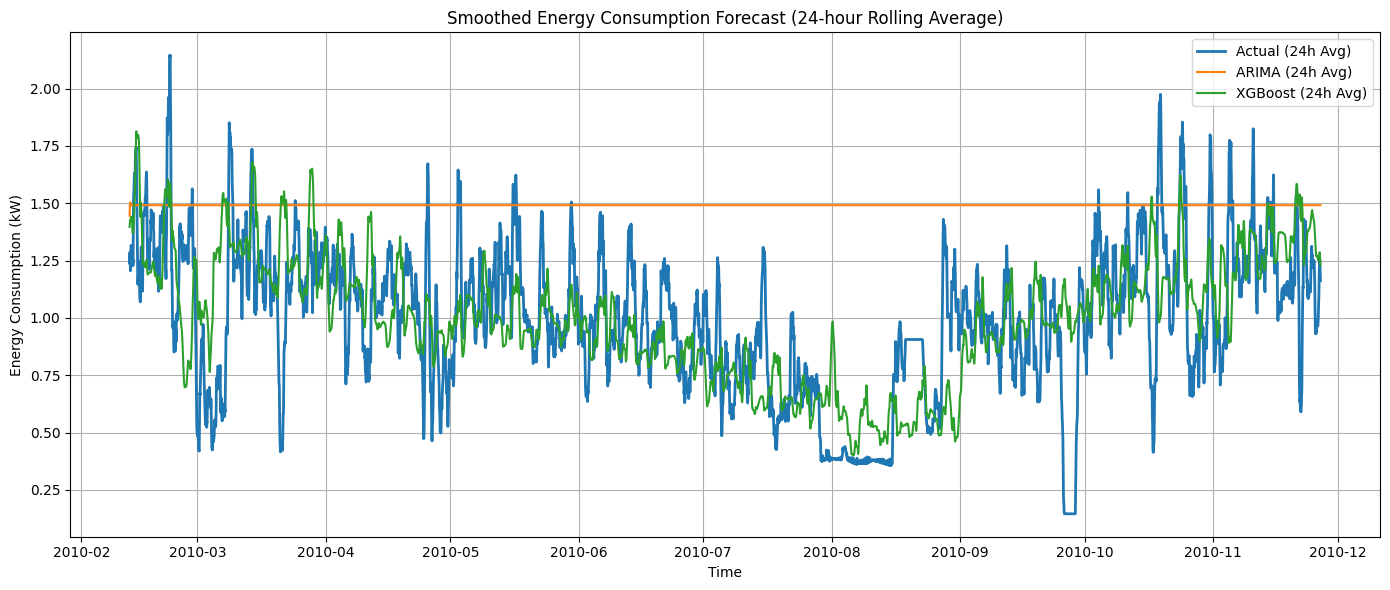

In [27]:
plt.figure(figsize=(14,6))

plt.plot(test.index, test["energy"].rolling(24).mean(),
         label="Actual (24h Avg)", linewidth=2)

plt.plot(test.index, pd.Series(arima_forecast, index=test.index).rolling(24).mean(),
         label="ARIMA (24h Avg)")

plt.plot(test.index, pd.Series(xgb_pred, index=test.index).rolling(24).mean(),
         label="XGBoost (24h Avg)")

plt.title("Smoothed Energy Consumption Forecast (24-hour Rolling Average)")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
